In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))

from itertools import cycle
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from scipy import interp

from src.data.load_data_set import load_data_set
from src.config.load_config import load_config

In [2]:
def load_model(model_name: str, model_directory: Path):
    model_file = model_directory/f"{model_name}.json"
    model_weights = model_directory/f"{model_name}.h5"
    
    with open(model_file) as json_file:
        loaded_model = model_from_json(json_file.read())
    
    # load weights into new model
    loaded_model.load_weights(str(model_weights))

    return loaded_model

In [3]:
config = load_config("../../config/1.0-TID-RPS-ISO-m3.yml")

In [13]:
model = load_model(config['model_name'], Path("../../models"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4333696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [36]:
data_processed_path = Path(config.get('data_processed_path', 'data/processed')) / config['model_name']
# data_processed_path = Path(config.get('data_processed_path', 'data/processed')) / 'TID-RPS-ISO-m3'


# test_data_set = load_data_set(config, Path("../..")/data_processed_path/'test')
test_data_set = load_data_set(config, Path("../..")/'data/interim')

In [37]:
predict = []
correct = []

prediction_history = []
correct_history = []

n_classes = config.get("data_num_classes", 2)
classes_count = [0] * n_classes

In [38]:
SAMPLES_PER_CLASS = 1000

tid_image = []

for image, label in test_data_set.take(1000):
    predictions = model.predict(image)

    for i in range(predictions.shape[0]):
        correct_val   = np.argmax(label[i])
        predicted_val = np.argmax(predictions[i])
        

        if classes_count[correct_val] > SAMPLES_PER_CLASS:
            continue

        classes_count[correct_val] += 1
        
        predict.append(predicted_val)
        correct.append(correct_val)

        prediction_history.append(predictions[i])
        correct_history.append(label[i])

        
        if all(map(lambda x: x >=SAMPLES_PER_CLASS, classes_count)):
        # if sum(classes_count) >= SAMPLES_PER_CLASS:
            break 
    if all(map(lambda x: x >=SAMPLES_PER_CLASS, classes_count)):
    # if sum(classes_count) >= SAMPLES_PER_CLASS:
            break 

### AUC Calculations

In [39]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [40]:
micro_hist_correct = []
micro_hist_predict = []

for i in range(n_classes):
    f = lambda y: list(map(lambda x: x[i], y))
    
    class_correct = f(correct_history)
    class_precict = f(prediction_history)

    micro_hist_correct += class_correct
    micro_hist_predict += class_precict
    
    fpr[i], tpr[i], _ = roc_curve(class_correct, class_precict)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(micro_hist_correct, micro_hist_predict)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

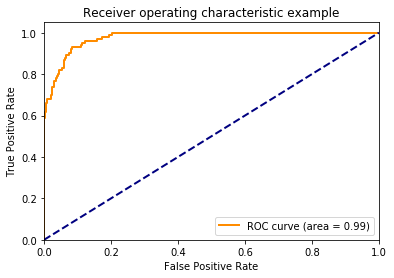

In [41]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


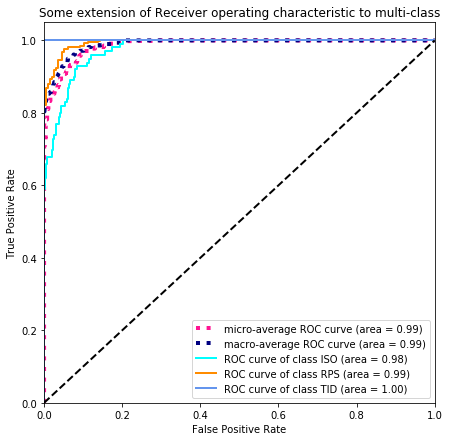

In [42]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

labels = sorted(config.get('data_labels', {}).values())
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [43]:
macro_roc_auc_ovo = roc_auc_score(correct_history, prediction_history, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(correct_history, prediction_history, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(correct_history, prediction_history, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(correct_history, prediction_history, multi_class="ovr",
                                     average="weighted")

# print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#       "(weighted by prevalence)"
#       .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
# print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#       "(weighted by prevalence)"
#       .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

data = [
    ["(One-vs-One) Macro", macro_roc_auc_ovo],
    ["(One-vs-One) Macro (weighted by prevalence)", weighted_roc_auc_ovo],
    ["(One-vs-Rest) Macro", macro_roc_auc_ovr],
    ["(One-vs-Rest) Macro (weighted by prevalence)", weighted_roc_auc_ovr]
]
pd.DataFrame(data, columns=["Metric", "AUC"])

,Metric,AUC
0,(One-vs-One) Macro,0.990381
1,(One-vs-One) Macro (weighted by prevalence),0.990386
2,(One-vs-Rest) Macro,0.990381
3,(One-vs-Rest) Macro (weighted by prevalence),0.990386


## Confusion Matrix

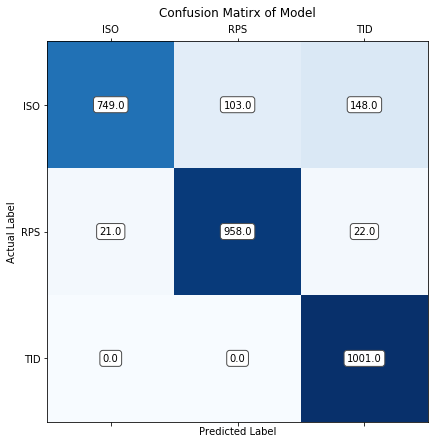

In [44]:
labels = sorted(config.get('data_labels', {}).values())
conf_mtrx = confusion_matrix(correct, predict, [i for i in range(n_classes)])

fig, ax = plt.subplots(figsize=(7, 7))

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(conf_mtrx, cmap="Blues")

for (i, j), z in np.ndenumerate(conf_mtrx):
    ax.text(
        j,i, 
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")


plt.title("Confusion Matirx of Model")

plt.show()

In [35]:
import numpy.ma as ma

i = 0
f = lambda y: list(map(lambda x: x[i], y))

predict = np.array(f(prediction_history))
correct = 1-np.array(f(correct_history))
accuracy = ma.masked_array(predict, mask=correct)

np.mean(accuracy)

0.6270025024414062